# HY-2B SCA L2A后向散射系数投影

In [2]:
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from skimage import exposure
from RSData import *
from HaiYangData import *

import datetime
import h5py
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import io
import cv2
import shutil
import os
import glob

In [2]:
def split_file_day(files):
    # 按照天来划分文件，同一天的内容在一个list里面
    file_list = []
    list = []
    for i in range(len(files)):

        if i == 0:
            list.append(files[i])
            continue

        if (files[i].split('_')[8].split('T')[0]) == (files[i-1].split('_')[8].split('T')[0]):
            list.append(files[i])
        else:
            file_list.append(list)
            list = []
            list.append(files[i])
    file_list.append(list)
    return file_list

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180,bbox_inches='tight',pad_inches = 0, edgecolor = 'white')
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img



def draw_sigmod_0(x_map, y_map, grid_array,save_path = None):
    fig = plt.figure(figsize=(9, 9))
    fig.add_subplot(111)
    fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

    # hy_m.fillcontinents()
    hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
    hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)
    # you can get a high-resolution image as numpy array!!
    if save_path:
        plt.savefig(save_path,dpi=180,bbox_inches='tight',pad_inches = 0, edgecolor = 'white')
    plt.close()
    
    return fig


In [14]:
satellite = r'HY2B'
sensor = r'SCA'
hy_sca = HaiYangData(satellite=satellite, sensor=sensor,resolution=30000)

# 将WGS 84坐标（4326）转化为极射投影
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")

dir_path = r"H:\remote_sensing_data\back_scatter\HY-2B"
# 20210608 处理pwp_250_07.h5
files = glob.glob(dir_path + '\*_pwp_250_03.h5')


files = files + glob.glob(dir_path + '\*_pwp_250_05.h5')
files = files + glob.glob(dir_path + '\*_pwp_250_07.h5')

files.sort()

file_list = split_file_day(files)

In [15]:
transformer = HaiYangData.set_transformer(crs,crs2)
transformer_back = HaiYangData.set_transformer(crs2,crs)

train_data_dir = r'D:\python_workfile\sea_ice_classification\training7\dataset\sig0'

In [16]:
value_array = np.empty(shape=(1702, 810,5))
grid_array = np.zeros((hy_sca.nlat, hy_sca.nlon))
grid_num_array = np.zeros((hy_sca.nlat, hy_sca.nlon))

for file in file_list[1]:
    with h5py.File(file, mode='r') as f:
        lat = f['cell_lat'][:]
        lon = f['cell_lon'][:]
        sigma0 = f['cell_sigma0'][:]

    sigma0 = sigma0*0.01

    lat[lat > 90] = 0 
    lon[lon > 360] = 0 
    sigma0[sigma0 < -300] = 0
#         projlats, projlons = transformer.transform(lat, lon)

    value_array[:,:,0] = lat
    value_array[:,:,1] = lon
    value_array[:,:,2],value_array[:,:,3] = transformer.transform(value_array[:,:,0], value_array[:,:,1])
    value_array[:,:,4] = sigma0
#     value_array[:,:,4][value_array[:,:,4] < -300] = np.nan

    x = (value_array[:,:,2] / hy_sca.resolution).astype(np.int)
    y = (value_array[:,:,3] / hy_sca.resolution).astype(np.int)
    grid_array[y,x] += value_array[:,:,4]
    grid_num_array[y,x] += 1

C:\Users\Administrator\AppData\Local\Temp/ipykernel_2228/2939705427.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = (value_array[:,:,2] / hy_sca.resolution).astype(np.int)
C:\Users\Administrator\AppData\Local\Temp/ipykernel_2228/2939705427.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

In [17]:
grid_array = grid_array / grid_num_array
x_map, y_map = hy_sca.get_map_grid(transformer_back)


C:\Users\Administrator\AppData\Local\Temp/ipykernel_2228/879451860.py:1: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array


C:\Users\Administrator\AppData\Local\Temp/ipykernel_2228/2330970123.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


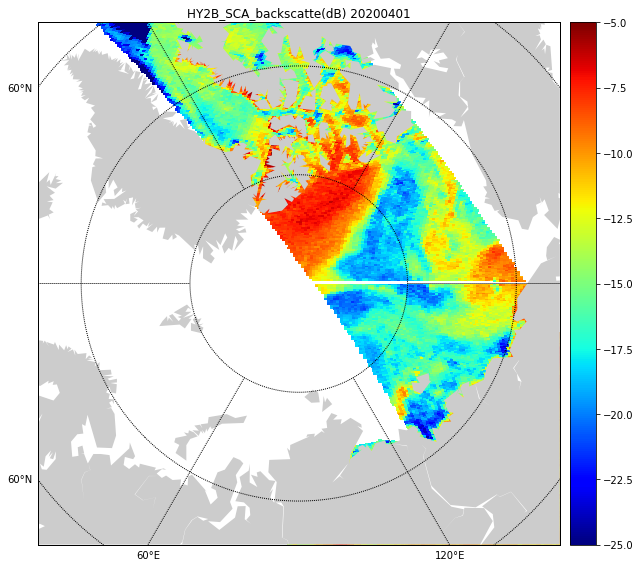

In [18]:
fig = plt.figure(figsize=(9, 9))
fig.add_subplot(111)
fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)
cb = hy_m.colorbar(location='right')
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title('HY2B_SCA_backscatte(dB) 20200401')
# you can get a high-resolution image as numpy array!!
plt.show()
plot_img_np = get_img_from_fig(fig)
# np.save((train_data_dir+ '\\npy\\HY2B_sca_sigmod0_'+str(name) + '.npy'), plot_img_np)
# print(name)

In [24]:
x_map, y_map = hy_sca.get_map_grid(transformer_back)

for files in file_list[:106]:
    name = files[0].split('_')[8].split('T')[0]
    value_array = np.empty(shape=(1702, 810,5))
    grid_array = np.zeros((hy_sca.nlat, hy_sca.nlon))
    grid_num_array = np.zeros((hy_sca.nlat, hy_sca.nlon))

    for file in files:
        try:
            with h5py.File(file, mode='r') as f:
                lat = f['cell_lat'][:]
                lon = f['cell_lon'][:]
                sigma0 = f['cell_sigma0'][:]
        except:
            continue
            print(file)
            

        sigma0 = sigma0*0.01

        lat[lat > 90] = 0 
        lon[lon > 360] = 0 
        sigma0[sigma0 < -300] = 0
#         projlats, projlons = transformer.transform(lat, lon)

        value_array[:,:,0] = lat
        value_array[:,:,1] = lon
        value_array[:,:,2],value_array[:,:,3] = transformer.transform(value_array[:,:,0], value_array[:,:,1])
        value_array[:,:,4] = sigma0
    #     value_array[:,:,4][value_array[:,:,4] < -300] = np.nan

        x = (value_array[:,:,2] / hy_sca.resolution).astype(np.int)
        y = (value_array[:,:,3] / hy_sca.resolution).astype(np.int)
        grid_array[y,x] += value_array[:,:,4]
        grid_num_array[y,x] += 1
        
    grid_array = grid_array / grid_num_array

    fig = draw_sigmod_0(x_map, y_map, grid_array,train_data_dir + '\\pic\\' + str(name) + '.png')
#     fig = draw_sigmod_0(x_map, y_map, grid_array)
    plot_img_np = get_img_from_fig(fig)
#     np.save((train_data_dir+ '\\npy\\grid\\'+str(name) + '.npy'), grid_array)
    print(name)

<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190514


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190519


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190520


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190521


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190526


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190527


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190528


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190908


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190909


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190910


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190914


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190915


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190916


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190917


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190923


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190924


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190929


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20190930


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191001


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191005


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191006


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191007


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191008


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191013


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191014


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191015


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191019


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191020


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191021


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191022


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191027


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191028


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191029


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191102


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191103


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191104


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191105


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191109


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191110


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191111


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191112


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191116


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191117


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191118


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191119


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191124


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191125


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191126


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191130


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191201


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191202


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191203


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191207


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191208


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191209


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191210


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191214


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191215


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191216


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191217


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191222


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191223


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191224


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191229


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191230


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20191231


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200106


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200107


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200112


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200113


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200114


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200119


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200120


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200121


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200126


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200127


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200128


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200202


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200203


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200204


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200209


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200210


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200211


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200216


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200217


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200218


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200223


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200224


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200225


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200301


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200302


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200303


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200308


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200309


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200310


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200314


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200315


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200316


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200317


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200322


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200323


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200324


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200329


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200330


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200331


<ipython-input-24-605484972bf9>:38: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-4-62a2f12ec23a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


20200401


    
    fig = draw_sigmod_0(x_map, y_map, grid_array)
    plot_img_np = get_img_from_fig(fig)

    name = files[6].split('_')[8].split('T')[0]

    np.savez((r'.\\npy\\sigmod0_'+ str(name) + '.npz'), plot_img_np)


# 修改文件名称

In [14]:


path=r'E:\python_workfile\sea_ice_classification\training4\sigmod0'      

#获取该目录下所有文件，存入列表中
fileList=glob.glob(path+'\\HY2B_sca_sigmod0_'+'*.png')


n=0
for i in fileList:
    
    #设置旧文件名（就是路径+文件名）
    oldname=i   # os.sep添加系统分隔符
    
    #设置新文件名
    newname=path + '\\' +i.split('\\')[-1].split('_')[-1]
    
    os.rename(oldname,newname)   #用os模块中的rename方法对文件改名
    print(oldname,'======>',newname)
    
    n+=1

# 将AARI 与HY-2B daily数据 1天向多天映射

In [3]:

sig_dir = r'E:\python_workfile\sea_ice_classification\training7\dataset\input_value\VV_HH_polarratio'
aari_dir = r'E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic'

sig_files = glob.glob(sig_dir+'\\*.png')
aari_files = glob.glob(aari_dir + '\\*.png')


In [6]:

i,j = 0,0
while i <len(aari_files)-1:
    while j < len(sig_files)-1:
        aari_day = aari_files[i].split('\\')[-1].split('.')[0]
        sig_day = sig_files[j].split('\\')[-1].split('.')[0]
        aari_d = datetime.date(year=int(aari_day[:4]), month=int(aari_day[4:6]), day=int(aari_day[6:8]))
        sig_d = datetime.date(year=int(sig_day[:4]), month=int(sig_day[4:6]), day=int(sig_day[6:8]))
        print(aari_day, sig_day)
        print((aari_d - sig_d).days)
        if aari_d == sig_d:
            i += 1
            j += 1
        elif ((aari_d - sig_d).days <= 7)& ((aari_d - sig_d).days > 0):
            shutil.copyfile(aari_files[i], aari_dir+'\\'+str(sig_day)+'.png')
            j+=1
            print(aari_files[i],'======>', aari_dir+'\\'+str(sig_day)+'.png')
        elif ((aari_d - sig_d).days > 7):
            j+=1
        else:
            i+=1
            

20180102 20190514
-497
20180109 20190514
-490
20180116 20190514
-483
20180123 20190514
-476
20180130 20190514
-469
20180206 20190514
-462
20180213 20190514
-455
20180220 20190514
-448
20180227 20190514
-441
20180306 20190514
-434
20180313 20190514
-427
20180320 20190514
-420
20180327 20190514
-413
20180403 20190514
-406
20180410 20190514
-399
20180417 20190514
-392
20180424 20190514
-385
20180501 20190514
-378
20180515 20190514
-364
20180522 20190514
-357
20180529 20190514
-350
20180605 20190514
-343
20180612 20190514
-336
20180619 20190514
-329
20180626 20190514
-322
20180703 20190514
-315
20180710 20190514
-308
20180717 20190514
-301
20180724 20190514
-294
20180731 20190514
-287
20180807 20190514
-280
20180814 20190514
-273
20180821 20190514
-266
20180828 20190514
-259
20180904 20190514
-252
20180911 20190514
-245
20180918 20190514
-238
20180925 20190514
-231
20181002 20190514
-224
20181009 20190514
-217
20181016 20190514
-210
20181030 20190514
-196
20181106 20190514
-189
20181113 20

E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20200204.png ======> E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20200203.png
20200204 20200204
0
20200211 20200205
6
E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20200211.png ======> E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20200205.png
20200211 20200206
5
E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20200211.png ======> E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20200206.png
20200211 20200207
4
E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20200211.png ======> E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20200207.png
20200211 20200208
3
E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20200211.png ======> E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20200208.png
20200211 20200209
2
E:\python_workfile\s

E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20201208.png ======> E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20201203.png
20201208 20201204
4
E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20201208.png ======> E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20201204.png
20201208 20201205
3
E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20201208.png ======> E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20201205.png
20201208 20201206
2
E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20201208.png ======> E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20201206.png
20201208 20201207
1
E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20201208.png ======> E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic\20201207.png
20201208 20201208
0
20201215 20201209
6
E:\python_workfile\s

# 将AARI 与HY-2B daily图片 1天向3天映射

In [59]:
import shutil
sig_dir = r'E:\python_workfile\sea_ice_classification\training4\sigmod0\fill_value'
aari_dir = r'E:\python_workfile\sea_ice_classification\training4\mask'

sig_files = glob.glob(sig_dir+'\\*.png')
aari_files = glob.glob(aari_dir + '\\*.png')


In [58]:

i,j = 0,0
while i <len(aari_files)-1:
    while j < len(sig_files)-1:
        aari_day = int(aari_files[i].split('\\')[-1].split('.')[0])
        sig_day = int(sig_files[j].split('\\')[-1].split('.')[0])
        print(aari_day, sig_day)
        if aari_day == sig_day:
            i += 1
            j += 1
        elif (aari_day - sig_day < 3)& (aari_day - sig_day > 0):
            shutil.copyfile(aari_files[i], aari_dir+'\\'+str(sig_day)+'.png')
            j+=1
            print(aari_files[i],'======>', aari_dir+'\\'+str(sig_day)+'.png')
        else:
            i+=1

20200407 20200405
E:\python_workfile\sea_ice_classification\training4\mask\20200407.png ======> E:\python_workfile\sea_ice_classification\training4\mask\20200405.png
20200407 20200406
E:\python_workfile\sea_ice_classification\training4\mask\20200407.png ======> E:\python_workfile\sea_ice_classification\training4\mask\20200406.png
20200407 20200407
20200414 20200412
E:\python_workfile\sea_ice_classification\training4\mask\20200414.png ======> E:\python_workfile\sea_ice_classification\training4\mask\20200412.png
20200414 20200413
E:\python_workfile\sea_ice_classification\training4\mask\20200414.png ======> E:\python_workfile\sea_ice_classification\training4\mask\20200413.png
20200414 20200414
20200421 20200419
E:\python_workfile\sea_ice_classification\training4\mask\20200421.png ======> E:\python_workfile\sea_ice_classification\training4\mask\20200419.png
20200421 20200420
E:\python_workfile\sea_ice_classification\training4\mask\20200421.png ======> E:\python_workfile\sea_ice_classificat